In [ ]:
import pandas as pd
df=pd.read_csv("BTC_1sec.csv")

In [ ]:
df

,Unnamed: 0,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030723,1030723,2021-04-19 09:54:18.386544+00:00,56863.725,0.01,0.000000,0.000000,-8.792952e-08,-2.637886e-07,-0.000025,-0.000026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1030724,1030724,2021-04-19 09:54:19.386544+00:00,56863.725,0.01,0.000000,0.000000,-8.792952e-08,-2.637886e-07,-0.000026,-0.000031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1030725,1030725,2021-04-19 09:54:20.386544+00:00,56863.725,0.01,1506.866100,0.000000,-8.792952e-08,-2.637886e-07,-0.000026,-0.000034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1030726,1030726,2021-04-19 09:54:21.386544+00:00,56863.725,0.01,0.000000,0.000000,-8.792952e-08,-2.637886e-07,-0.000026,-0.000034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['system_time'] = pd.to_datetime(df['system_time'])

In [ ]:
import pandas as pd
import numpy as np

# Load your LOB data (assuming already loaded as `df`)
# Ensure proper datetime
df['system_time'] = pd.to_datetime(df['system_time'])

# Parameters
window_seconds = 60
step_seconds = 10
min_net_volume = 100  # BTC
min_directionality = 0.9

metaorders = []

# Ensure data is sorted
df = df.sort_values('system_time').reset_index(drop=True)

# Convert to numpy for speed
timestamps = df['system_time'].values
midpoints = df['midpoint'].values
buys = df['buys'].values
sells = df['sells'].values

i = 0
while i < len(df):
    t_start = df['system_time'].iloc[i]
    t_end = t_start + pd.Timedelta(seconds=window_seconds)

    window_df = df[(df['system_time'] >= t_start) & (df['system_time'] < t_end)]

    if len(window_df) < 10:
        i += step_seconds
        continue  # Skip sparse windows

    total_buys = window_df['buys'].sum()
    total_sells = window_df['sells'].sum()
    net_volume = total_buys - total_sells
    total_volume = total_buys + total_sells

    if total_volume == 0:
        i += step_seconds
        continue

    directionality = abs(net_volume) / total_volume
    if directionality < min_directionality or abs(net_volume) < min_net_volume:
        i += step_seconds
        continue

    midpoint_start = window_df['midpoint'].iloc[0]
    midpoint_end = window_df['midpoint'].iloc[-1]
    delta_p = midpoint_end - midpoint_start

    metaorders.append({
        'start_time': t_start,
        'end_time': t_end,
        'direction': np.sign(net_volume),
        'Q': abs(net_volume),
        'ΔP': delta_p,
        'mid_start': midpoint_start,
        'mid_end': midpoint_end,
        'Q_over_V': abs(net_volume) / total_volume
    })

    i += step_seconds  # Slide the window

metaorders_df = pd.DataFrame(metaorders)


In [ ]:
metaorders_df

,start_time,end_time,direction,Q,ΔP,mid_start,mid_end,Q_over_V
0,2021-04-07 12:43:12.122161+00:00,2021-04-07 12:44:12.122161+00:00,1.0,9.969273e+05,72.230,56337.835,56410.065,0.929206
1,2021-04-07 12:55:12.122161+00:00,2021-04-07 12:56:12.122161+00:00,1.0,9.311370e+05,39.510,56489.005,56528.515,0.912003
2,2021-04-07 13:31:52.122161+00:00,2021-04-07 13:32:52.122161+00:00,1.0,2.003437e+06,57.210,56571.085,56628.295,0.908435
3,2021-04-07 14:28:32.122161+00:00,2021-04-07 14:29:32.122161+00:00,1.0,6.639931e+05,50.180,56804.095,56854.275,0.945602
4,2021-04-07 14:28:42.122161+00:00,2021-04-07 14:29:42.122161+00:00,1.0,5.982688e+05,43.030,56811.305,56854.335,0.922671
...,...,...,...,...,...,...,...,...
3039,2021-04-19 09:38:55.386544+00:00,2021-04-19 09:39:55.386544+00:00,-1.0,9.721629e+05,-47.550,57140.615,57093.065,0.951818
3040,2021-04-19 09:39:05.386544+00:00,2021-04-19 09:40:05.386544+00:00,-1.0,9.433384e+05,-32.380,57140.055,57107.675,0.930848
3041,2021-04-19 09:39:15.386544+00:00,2021-04-19 09:40:15.386544+00:00,-1.0,1.118498e+06,-56.845,57145.880,57089.035,0.933844
3042,2021-04-19 09:39:25.386544+00:00,2021-04-19 09:40:25.386544+00:00,-1.0,1.130750e+06,-33.470,57122.785,57089.315,0.953494


Fitted power law: |ΔP| = exp(3.1970) * (Q/V)^-0.1372


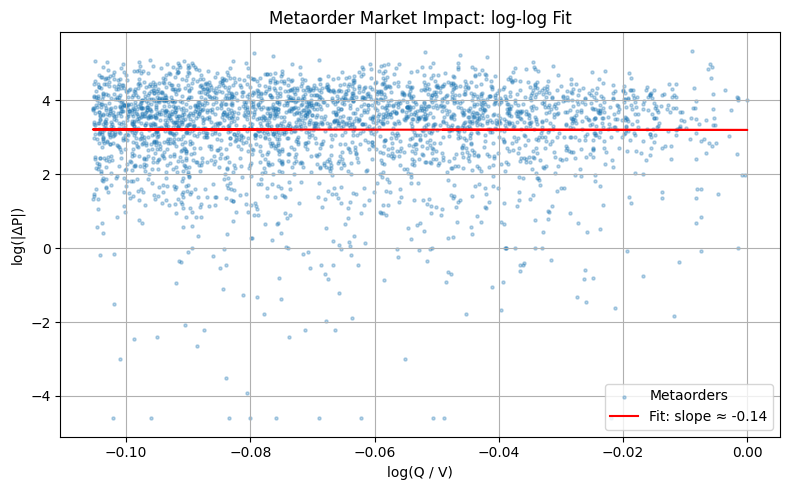

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


df = metaorders_df.copy()
df = df[(df['ΔP'] != 0) & (df['Q_over_V'] > 0)]

# Log-transform
df['log_QV'] = np.log(df['Q_over_V'])
df['log_dP'] = np.log(np.abs(df['ΔP']))

# Fit linear regression
X = df[['log_QV']]
y = df['log_dP']
reg = LinearRegression().fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_

print(f"Fitted power law: |ΔP| = exp({intercept:.4f}) * (Q/V)^{slope:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(df['log_QV'], df['log_dP'], s=5, alpha=0.3, label='Metaorders')
plt.plot(df['log_QV'], reg.predict(X), color='red', label='Fit: slope ≈ {:.2f}'.format(slope))
plt.xlabel('log(Q / V)')
plt.ylabel('log(|ΔP|)')
plt.title('Metaorder Market Impact: log-log Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df

,start_time,end_time,direction,Q,ΔP,mid_start,mid_end,Q_over_V,log_QV,log_dP
0,2021-04-07 12:43:12.122161+00:00,2021-04-07 12:44:12.122161+00:00,1.0,9.969273e+05,72.230,56337.835,56410.065,0.929206,-0.073424,4.279855
1,2021-04-07 12:55:12.122161+00:00,2021-04-07 12:56:12.122161+00:00,1.0,9.311370e+05,39.510,56489.005,56528.515,0.912003,-0.092112,3.676554
2,2021-04-07 13:31:52.122161+00:00,2021-04-07 13:32:52.122161+00:00,1.0,2.003437e+06,57.210,56571.085,56628.295,0.908435,-0.096032,4.046729
3,2021-04-07 14:28:32.122161+00:00,2021-04-07 14:29:32.122161+00:00,1.0,6.639931e+05,50.180,56804.095,56854.275,0.945602,-0.055934,3.915617
4,2021-04-07 14:28:42.122161+00:00,2021-04-07 14:29:42.122161+00:00,1.0,5.982688e+05,43.030,56811.305,56854.335,0.922671,-0.080482,3.761898
...,...,...,...,...,...,...,...,...,...,...
3039,2021-04-19 09:38:55.386544+00:00,2021-04-19 09:39:55.386544+00:00,-1.0,9.721629e+05,-47.550,57140.615,57093.065,0.951818,-0.049381,3.861782
3040,2021-04-19 09:39:05.386544+00:00,2021-04-19 09:40:05.386544+00:00,-1.0,9.433384e+05,-32.380,57140.055,57107.675,0.930848,-0.071659,3.477541
3041,2021-04-19 09:39:15.386544+00:00,2021-04-19 09:40:15.386544+00:00,-1.0,1.118498e+06,-56.845,57145.880,57089.035,0.933844,-0.068446,4.040328
3042,2021-04-19 09:39:25.386544+00:00,2021-04-19 09:40:25.386544+00:00,-1.0,1.130750e+06,-33.470,57122.785,57089.315,0.953494,-0.047623,3.510650


In [ ]:
df = metaorders_df.copy()
min_dP = 93 # Or adjust depending on your asset tick size / scale
df = df[np.abs(df['ΔP']) > min_dP]
df

,start_time,end_time,direction,Q,ΔP,mid_start,mid_end,Q_over_V
7,2021-04-07 14:31:02.122161+00:00,2021-04-07 14:32:02.122161+00:00,1.0,1.891924e+06,97.48,56820.045,56917.525,0.930777
11,2021-04-07 16:53:43.626760+00:00,2021-04-07 16:54:43.626760+00:00,-1.0,7.829543e+06,-121.34,56762.635,56641.295,0.943361
20,2021-04-07 18:39:43.626760+00:00,2021-04-07 18:40:43.626760+00:00,1.0,3.479805e+06,101.26,56021.625,56122.885,0.917852
23,2021-04-07 18:48:53.626760+00:00,2021-04-07 18:49:53.626760+00:00,1.0,1.919203e+06,97.71,55949.035,56046.745,0.919180
25,2021-04-07 18:50:33.626760+00:00,2021-04-07 18:51:33.626760+00:00,1.0,6.806990e+05,95.97,56061.245,56157.215,0.962227
...,...,...,...,...,...,...,...,...
2991,2021-04-19 06:19:14.118284+00:00,2021-04-19 06:20:14.118284+00:00,1.0,3.289756e+05,95.17,56946.155,57041.325,0.931315
3006,2021-04-19 07:37:24.118284+00:00,2021-04-19 07:38:24.118284+00:00,1.0,1.726055e+06,118.16,57399.155,57517.315,0.975261
3013,2021-04-19 08:02:15.386544+00:00,2021-04-19 08:03:15.386544+00:00,1.0,1.103097e+05,112.34,57438.535,57550.875,0.927893
3014,2021-04-19 08:02:25.386544+00:00,2021-04-19 08:03:25.386544+00:00,1.0,1.587680e+05,104.58,57465.415,57569.995,0.922735


Fitted power law: |ΔP| = exp(4.7913) * (Q/V)^0.4696


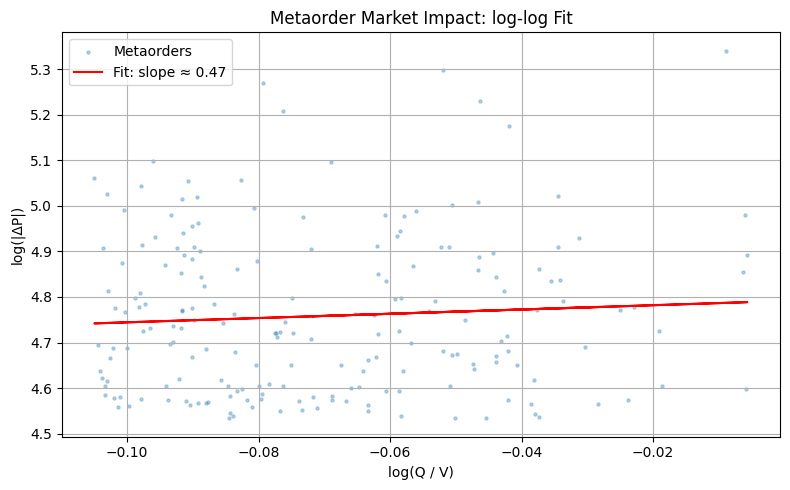

In [ ]:

# Log-transform
df['log_QV'] = np.log(df['Q_over_V'])
df['log_dP'] = np.log(np.abs(df['ΔP']))

# Fit linear regression
X = df[['log_QV']]
y = df['log_dP']
reg = LinearRegression().fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_

print(f"Fitted power law: |ΔP| = exp({intercept:.4f}) * (Q/V)^{slope:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(df['log_QV'], df['log_dP'], s=5, alpha=0.3, label='Metaorders')
plt.plot(df['log_QV'], reg.predict(X), color='red', label='Fit: slope ≈ {:.2f}'.format(slope))
plt.xlabel('log(Q / V)')
plt.ylabel('log(|ΔP|)')
plt.title('Metaorder Market Impact: log-log Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df=pd.read_csv("ETH_1sec.csv")
df['system_time'] = pd.to_datetime(df['system_time'])

import pandas as pd
import numpy as np

# Load your LOB data (assuming already loaded as `df`)
# Ensure proper datetime
df['system_time'] = pd.to_datetime(df['system_time'])

# Parameters
window_seconds = 60
step_seconds = 10
min_net_volume = 100  # BTC
min_directionality = 0.9

metaorders = []

# Ensure data is sorted
df = df.sort_values('system_time').reset_index(drop=True)

# Convert to numpy for speed
timestamps = df['system_time'].values
midpoints = df['midpoint'].values
buys = df['buys'].values
sells = df['sells'].values

i = 0
while i < len(df):
    t_start = df['system_time'].iloc[i]
    t_end = t_start + pd.Timedelta(seconds=window_seconds)

    window_df = df[(df['system_time'] >= t_start) & (df['system_time'] < t_end)]

    if len(window_df) < 10:
        i += step_seconds
        continue  # Skip sparse windows

    total_buys = window_df['buys'].sum()
    total_sells = window_df['sells'].sum()
    net_volume = total_buys - total_sells
    total_volume = total_buys + total_sells

    if total_volume == 0:
        i += step_seconds
        continue

    directionality = abs(net_volume) / total_volume
    if directionality < min_directionality or abs(net_volume) < min_net_volume:
        i += step_seconds
        continue

    midpoint_start = window_df['midpoint'].iloc[0]
    midpoint_end = window_df['midpoint'].iloc[-1]
    delta_p = midpoint_end - midpoint_start

    metaorders.append({
        'start_time': t_start,
        'end_time': t_end,
        'direction': np.sign(net_volume),
        'Q': abs(net_volume),
        'ΔP': delta_p,
        'mid_start': midpoint_start,
        'mid_end': midpoint_end,
        'Q_over_V': abs(net_volume) / total_volume
    })

    i += step_seconds  # Slide the window

metaorders_df = pd.DataFrame(metaorders)


In [ ]:
metaorders_df

,start_time,end_time,direction,Q,ΔP,mid_start,mid_end,Q_over_V
0,2021-04-07 11:44:40.861733+00:00,2021-04-07 11:45:40.861733+00:00,-1.0,3.588272e+06,-11.770,1970.565,1958.795,0.911158
1,2021-04-07 12:42:40.861733+00:00,2021-04-07 12:43:40.861733+00:00,1.0,8.728183e+05,0.020,1972.300,1972.320,0.904950
2,2021-04-07 13:34:30.861733+00:00,2021-04-07 13:35:30.861733+00:00,1.0,9.284194e+05,2.630,1994.185,1996.815,0.962300
3,2021-04-07 13:34:40.861733+00:00,2021-04-07 13:35:40.861733+00:00,1.0,7.842454e+05,3.115,1994.130,1997.245,0.963288
4,2021-04-07 13:34:50.861733+00:00,2021-04-07 13:35:50.861733+00:00,1.0,6.917145e+05,3.770,1994.725,1998.495,0.912127
...,...,...,...,...,...,...,...,...
1434,2021-04-11 02:29:42.009457+00:00,2021-04-11 02:30:42.009457+00:00,1.0,6.182011e+04,-0.110,2148.185,2148.075,0.956151
1435,2021-04-11 02:29:52.009457+00:00,2021-04-11 02:30:52.009457+00:00,1.0,4.986233e+04,-0.070,2148.145,2148.075,0.961884
1436,2021-04-11 02:30:02.009457+00:00,2021-04-11 02:31:02.009457+00:00,1.0,4.321305e+04,-0.120,2148.195,2148.075,0.970299
1437,2021-04-11 02:30:12.009457+00:00,2021-04-11 02:31:12.009457+00:00,1.0,4.087614e+04,0.060,2148.015,2148.075,0.985135


Fitted power law: |ΔP| = exp(-0.0739) * (Q/V)^-0.1021


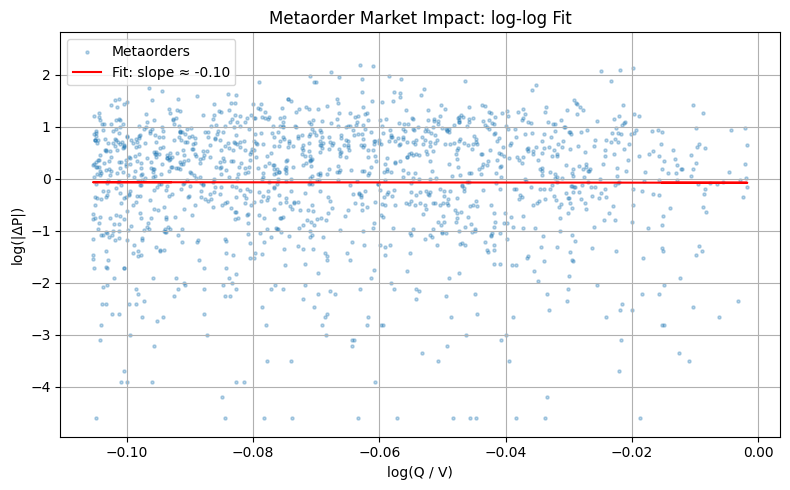

In [ ]:
df = metaorders_df.copy()
df = df[(df['ΔP'] != 0) & (df['Q_over_V'] > 0)]

# Log-transform
df['log_QV'] = np.log(df['Q_over_V'])
df['log_dP'] = np.log(np.abs(df['ΔP']))

# Fit linear regression
X = df[['log_QV']]
y = df['log_dP']
reg = LinearRegression().fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_

print(f"Fitted power law: |ΔP| = exp({intercept:.4f}) * (Q/V)^{slope:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(df['log_QV'], df['log_dP'], s=5, alpha=0.3, label='Metaorders')
plt.plot(df['log_QV'], reg.predict(X), color='red', label='Fit: slope ≈ {:.2f}'.format(slope))
plt.xlabel('log(Q / V)')
plt.ylabel('log(|ΔP|)')
plt.title('Metaorder Market Impact: log-log Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Fitted power law: |ΔP| = exp(0.7427) * (Q/V)^0.5828


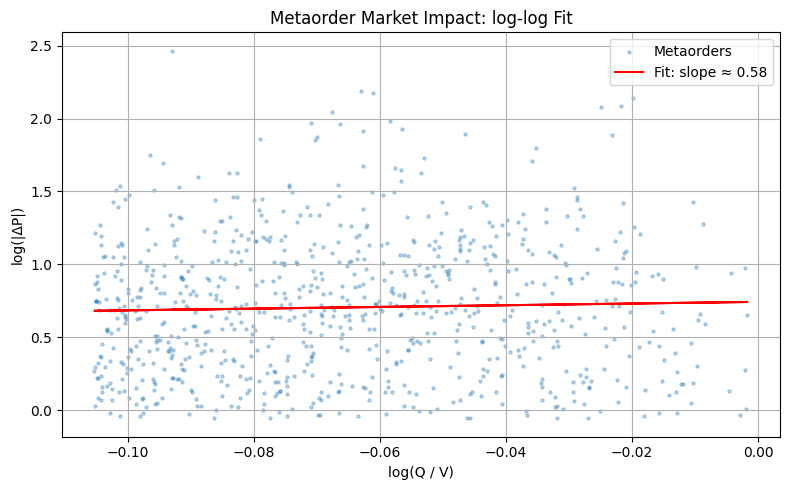

In [ ]:
df = metaorders_df.copy()
min_dP = 0.94
df = df[np.abs(df['ΔP']) > min_dP]
df['log_QV'] = np.log(df['Q_over_V'])
df['log_dP'] = np.log(np.abs(df['ΔP']))

# Fit linear regression
X = df[['log_QV']]
y = df['log_dP']
reg = LinearRegression().fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_

print(f"Fitted power law: |ΔP| = exp({intercept:.4f}) * (Q/V)^{slope:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(df['log_QV'], df['log_dP'], s=5, alpha=0.3, label='Metaorders')
plt.plot(df['log_QV'], reg.predict(X), color='red', label='Fit: slope ≈ {:.2f}'.format(slope))
plt.xlabel('log(Q / V)')
plt.ylabel('log(|ΔP|)')
plt.title('Metaorder Market Impact: log-log Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df=pd.read_csv("ADA_1sec.csv")
df['system_time'] = pd.to_datetime(df['system_time'])

import pandas as pd
import numpy as np

# Load your LOB data (assuming already loaded as `df`)
# Ensure proper datetime
df['system_time'] = pd.to_datetime(df['system_time'])

# Parameters
window_seconds = 60
step_seconds = 10
min_net_volume = 100  # BTC
min_directionality = 0.9

metaorders = []

# Ensure data is sorted
df = df.sort_values('system_time').reset_index(drop=True)

# Convert to numpy for speed
timestamps = df['system_time'].values
midpoints = df['midpoint'].values
buys = df['buys'].values
sells = df['sells'].values

i = 0
while i < len(df):
    t_start = df['system_time'].iloc[i]
    t_end = t_start + pd.Timedelta(seconds=window_seconds)

    window_df = df[(df['system_time'] >= t_start) & (df['system_time'] < t_end)]

    if len(window_df) < 10:
        i += step_seconds
        continue  # Skip sparse windows

    total_buys = window_df['buys'].sum()
    total_sells = window_df['sells'].sum()
    net_volume = total_buys - total_sells
    total_volume = total_buys + total_sells

    if total_volume == 0:
        i += step_seconds
        continue

    directionality = abs(net_volume) / total_volume
    if directionality < min_directionality or abs(net_volume) < min_net_volume:
        i += step_seconds
        continue

    midpoint_start = window_df['midpoint'].iloc[0]
    midpoint_end = window_df['midpoint'].iloc[-1]
    delta_p = midpoint_end - midpoint_start

    metaorders.append({
        'start_time': t_start,
        'end_time': t_end,
        'direction': np.sign(net_volume),
        'Q': abs(net_volume),
        'ΔP': delta_p,
        'mid_start': midpoint_start,
        'mid_end': midpoint_end,
        'Q_over_V': abs(net_volume) / total_volume
    })

    i += step_seconds  # Slide the window

metaorders_df = pd.DataFrame(metaorders)


In [ ]:
metaorders_df

,start_time,end_time,direction,Q,ΔP,mid_start,mid_end,Q_over_V
0,2021-04-07 12:51:00.055697+00:00,2021-04-07 12:52:00.055697+00:00,1.0,30710.153829,0.00170,1.18760,1.18930,0.959275
1,2021-04-07 14:09:30.055697+00:00,2021-04-07 14:10:30.055697+00:00,1.0,47339.189709,0.00265,1.19895,1.20160,0.944668
2,2021-04-07 14:09:40.055697+00:00,2021-04-07 14:10:40.055697+00:00,1.0,40996.279816,0.00065,1.20050,1.20115,0.911233
3,2021-04-07 14:55:20.055697+00:00,2021-04-07 14:56:20.055697+00:00,1.0,27188.391080,-0.00025,1.19530,1.19505,0.949723
4,2021-04-07 14:55:30.055697+00:00,2021-04-07 14:56:30.055697+00:00,1.0,27045.771153,0.00000,1.19535,1.19535,0.953988
...,...,...,...,...,...,...,...,...
1942,2021-04-11 04:31:52.066133+00:00,2021-04-11 04:32:52.066133+00:00,1.0,34309.508166,0.00090,1.21895,1.21985,0.917568
1943,2021-04-11 04:32:02.066133+00:00,2021-04-11 04:33:02.066133+00:00,1.0,25543.129164,0.00080,1.21905,1.21985,0.975886
1944,2021-04-11 04:51:52.066133+00:00,2021-04-11 04:52:52.066133+00:00,-1.0,139887.615558,-0.00125,1.21525,1.21400,0.904983
1945,2021-04-11 04:52:02.066133+00:00,2021-04-11 04:53:02.066133+00:00,-1.0,140110.284315,-0.00125,1.21535,1.21410,0.907413


Fitted power law: |ΔP| = exp(-6.4859) * (Q/V)^0.4870


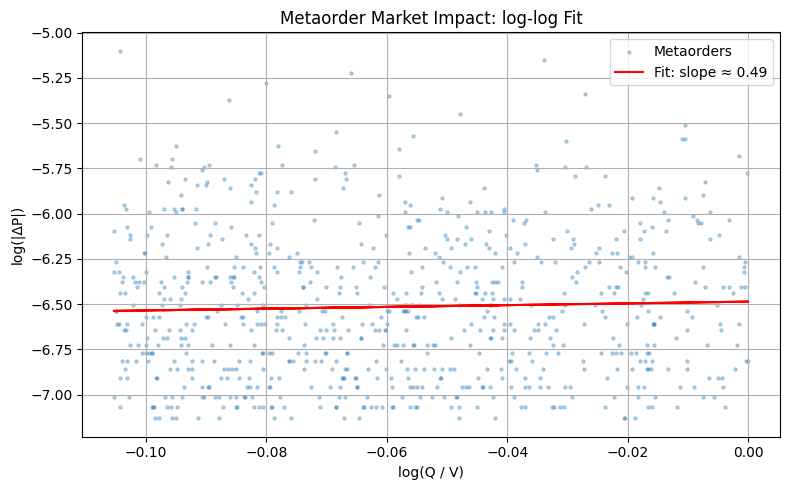

In [ ]:
df = metaorders_df.copy()
min_dP = 0.8e-3
df = df[np.abs(df['ΔP']) > min_dP]
df['log_QV'] = np.log(df['Q_over_V'])
df['log_dP'] = np.log(np.abs(df['ΔP']))

# Fit linear regression
X = df[['log_QV']]
y = df['log_dP']
reg = LinearRegression().fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_

print(f"Fitted power law: |ΔP| = exp({intercept:.4f}) * (Q/V)^{slope:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(df['log_QV'], df['log_dP'], s=5, alpha=0.3, label='Metaorders')
plt.plot(df['log_QV'], reg.predict(X), color='red', label='Fit: slope ≈ {:.2f}'.format(slope))
plt.xlabel('log(Q / V)')
plt.ylabel('log(|ΔP|)')
plt.title('Metaorder Market Impact: log-log Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
df_btc=pd.read_csv("BTC_1sec.csv")
df_ada=pd.read_csv("ADA_1sec.csv")
df_eth=pd.read_csv("ETH_1sec.csv")
import numpy as np

In [ ]:
for i in range (15):
  df_btc[f'bids_distance_{i}'] = df_btc['midpoint']- np.exp(df_btc[f'bids_distance_{i}'])*df_btc['midpoint']
  df_ada[f'bids_distance_{i}'] = df_ada['midpoint']- np.exp(df_ada[f'bids_distance_{i}'])*df_ada['midpoint']
  df_eth[f'bids_distance_{i}'] = df_eth['midpoint']- np.exp(df_eth[f'bids_distance_{i}'])*df_eth['midpoint']
  df_btc[f'asks_distance_{i}'] = df_btc['midpoint']- np.exp(df_btc[f'asks_distance_{i}'])*df_btc['midpoint']
  df_ada[f'asks_distance_{i}'] = df_ada['midpoint']- np.exp(df_ada[f'asks_distance_{i}'])*df_ada['midpoint']
  df_eth[f'asks_distance_{i}'] = df_eth['midpoint']- np.exp(df_eth[f'asks_distance_{i}'])*df_eth['midpoint']
df_ada

,Unnamed: 0,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,0,2021-04-07 11:33:00.055697+00:00,1.17075,0.0015,0.000000,0.0000,0.00075,0.00085,0.00095,0.00105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-04-07 11:33:01.055697+00:00,1.17005,0.0001,684.618694,74178.0000,0.00005,0.00015,0.00025,0.00055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-04-07 11:33:02.055697+00:00,1.17045,0.0009,1280.056786,1835.7300,0.00045,0.00055,0.00065,0.00075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-04-07 11:33:03.055697+00:00,1.17005,0.0001,5.487769,1111.9329,0.00005,0.00015,0.00025,0.00055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-04-07 11:33:04.055697+00:00,1.17005,0.0001,683.701131,712.8927,0.00005,0.00015,0.00025,0.00055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323172,322554,2021-04-11 05:09:16.066133+00:00,1.20855,0.0003,8.968554,0.0000,0.00015,0.00025,0.00045,0.00075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323173,322555,2021-04-11 05:09:17.066133+00:00,1.20870,0.0002,0.000000,0.0000,0.00010,0.00020,0.00030,0.00040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323174,322556,2021-04-11 05:09:18.066133+00:00,1.20870,0.0002,390.394048,0.0000,0.00010,0.00020,0.00030,0.00040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323175,322557,2021-04-11 05:09:19.066133+00:00,1.20865,0.0003,0.000000,0.0000,0.00015,0.00025,0.00035,0.00055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ts_btc=23000
for j in range (len (df_btc)):
  for i in range (1,15):
    k=i-1
    a=df_btc[f'bids_distance_{i}'][j] - df_btc[f'bids_distance_{k}'][j]
    if (a < ts_btc) and (a>0):
      ts_btc=a

ts_ada=23
for j in range (len (df_ada)):
  for i in range (1,15):
    k=i-1
    a=df_ada[f'bids_distance_{i}'][j] - df_ada[f'bids_distance_{k}'][j]
    if (a < ts_ada) and (a>0):
      ts_ada=a

ts_eth=23
for j in range (len (df_eth)):
  for i in range (1,15):
    k=i-1
    a=df_eth[f'bids_distance_{i}'][j] - df_eth[f'bids_distance_{k}'][j]
    if (a < ts_eth) and (a>0):
      ts_eth=a

print (ts_eth, ts_ada , ts_btc)


0.00994409446229838 9.944356781388386e-05 0.009904449863824993
